In [2]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
%load_ext google.cloud.bigquery

from IPython.display import clear_output
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.5)
#sns.set_style('darkgrid', {"xtick.minor.size": 10, "ytick.major.size": 10})
current_palette = sns.color_palette('deep')

In [62]:
df.attorney.str.replace('(?i)p\.c|p\.a', '', regex=True)\
            .str.replace('[\.]+', '', regex=True)\
            .str.replace('(?i)plc|incorporation|inc|ltd|llp|lpa|lp|pllc|llc|corporation|corp|company|firm|group', ' ', regex=True)\
            .str.replace(r'(?i)attn\:|attn', '', regex=True)\
            .str.extract(r"^(.*?)(?i:c\/o|$)", expand=False)\
            .str.replace(r'[\s]+', ' ', regex=True)\
            .str.strip()

0    Apple Apple
1          Apple
2          Apple
3          Apple
Name: attorney, dtype: object

# 1. Attorney Info

In [2]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '1_applnId_attorney'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
WITH ApplnLawyer_table AS(
    SELECT * EXCEPT(rank)
    FROM(
        SELECT 
            *,
            ROW_NUMBER() OVER (PARTITION BY appln_nr) AS rank
        FROM `usptobias.adding_data.15_appln_lawyer`
    )
    WHERE rank=1
)

SELECT 
    appln_id,
    attorney,
    attorney_id,
    attorney_region_code,
    attorney_country_code
FROM ApplnLawyer_table AS a
INNER JOIN `patents-public-data.uspto_oce_pair.match` AS b ON b.application_number_pair = a.appln_nr
LEFT JOIN `usptobias.usptobias_dataset.5_match_applnNrOrig_applnId` AS c ON c.appln_nr_orig = b.application_number
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [69]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '1_attorney_id'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
SELECT attorney_id, attorney
FROM `usptobias.adding_data.15_lawyer_uid_PAIR`
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

# 2. Inventors, applicants, and claims

## 2.1. Numbers

In [81]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '2_applnId_invt_claims'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
SELECT appln_id, publn_auth, publn_kind, publn_claims_earliest, publn_claims_grant, publn_date_earliest, publn_date_grant, nb_applt, nb_invt
FROM `usptobias.adding_data.14_nb_invt_applt_claim`
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

## 2.2. Inventors Table

In [17]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '2_inventors_patstat'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
WITH twins_table AS(
SELECT appln_id AS appln_id 
FROM `usptobias.patstat.tls201`
WHERE appln_auth='US' AND (appln_filing_year BETWEEN 2001 AND 2015)
)

SELECT 
    person_id,
    appln_id,
    applt_seq_nr,
    invt_seq_nr,
    UPPER(person_name) AS person_name,
    UPPER(psn_name) AS psn_name,
    UPPER(han_name) AS han_name,
    psn_sector,
    (CASE WHEN person_ctry_code='US' THEN 1 ELSE 0 END) AS is_US_resident,
    person_ctry_code AS invt_country_code
FROM `usptobias.patstat.tls207` AS a
INNER JOIN `usptobias.patstat.tls906` AS b USING(person_id)
INNER JOIN twins_table AS c USING(appln_id)
WHERE invt_seq_nr>0
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [72]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '2_inventors_uspto'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
SELECT 
    appln_id,
    UPPER(inventor_name_first) AS invt_name_first,
    UPPER(inventor_name_middle) AS invt_name_middle,
    UPPER(inventor_name_last) AS invt_name_last,
    inventor_rank AS invt_seq_nr,
    (CASE WHEN inventor_country_code='US' THEN 1 ELSE 0 END) AS is_US_resident,
    inventor_country_code AS invt_country_code
FROM `patents-public-data.uspto_oce_pair.all_inventors` AS a
INNER JOIN `patents-public-data.uspto_oce_pair.match` AS b ON b.application_number_pair = a.application_number
LEFT JOIN `usptobias.usptobias_dataset.5_match_applnNrOrig_applnId` AS c ON c.appln_nr_orig = b.application_number
INNER JOIN `usptobias.adding_data.13_AddedUSPTO` AS d USING(appln_id)
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [ ]:
# Checking The quality of Inventor Names

In [12]:
%%bigquery
SELECT 
    'Patstat' AS Name, 
    COUNT(DISTINCT CASE WHEN person_name IS NOT NULL THEN appln_id END) AS nb_total_appln,
    COUNT(DISTINCT psn_name) AS nb_total_invt
FROM `usptobias.usptobias_dataset.2_inventors_patstat` UNION ALL
SELECT 
    'USPTO' AS Name, 
    COUNT(DISTINCT CASE WHEN (invt_name_first IS NOT NULL) OR (invt_name_last IS NOT NULL) THEN appln_id END) AS nb_total_appln,
    COUNT(DISTINCT CASE WHEN (invt_name_first IS NOT NULL) OR (invt_name_last IS NOT NULL) THEN TO_JSON_STRING([invt_name_first, invt_name_middle, invt_name_last]) END) 
        AS nb_total_invt
FROM `usptobias.usptobias_dataset.2_inventors_uspto`

,Name,nb_total_appln,nb_total_invt
0,Patstat,8868277,5876167
1,USPTO,7399836,5154503


In [ ]:
# Checking how they can be mapped together

In [6]:
%%bigquery

WITH t1 AS(
    SELECT 
        REGEXP_REPLACE(person_name, r'[.,]', '') AS person_name, 
        ANY_VALUE(psn_name) AS psn_name
    FROM `usptobias.usptobias_dataset.2_inventors_patstat`
    GROUP BY person_name
), t2 AS(
    SELECT
        ARRAY_TO_STRING([name_last, name_middle, name_first], ' ') AS person_name,
        ANY_VALUE(name_last) AS name_last, 
        ANY_VALUE(name_middle) AS name_middle, 
        ANY_VALUE(name_first) AS name_first
    FROM(
        SELECT 
            REGEXP_REPLACE(invt_name_first, r'[.,]', '') AS name_first,
            REGEXP_REPLACE(invt_name_middle, r'[.,]', '') AS name_middle,
            REGEXP_REPLACE(invt_name_last, r'[.,]', '') AS name_last
        FROM `usptobias.usptobias_dataset.2_inventors_uspto`
    )
    GROUP BY person_name
)

SELECT 
    COUNT(DISTINCT t1.person_name) AS nb_total_patstat,
    COUNT(DISTINCT t2.person_name) AS nb_total_uspto,
    COUNT(DISTINCT CASE WHEN (t1.person_name IS NOT NULL) AND (t2.person_name IS NOT NULL) THEN t1.person_name END) AS nb_matched
FROM t1
FULL OUTER JOIN t2 ON t1.person_name = t2.person_name

,nb_total_patstat,nb_total_uspto,nb_matched
0,5434085,4084759,2193903


### 2.4.2 Updating Inventors table using "names_gender" and "names_ethnicity" tables

**"6_names_gender" and "6_names_origin" tables were created in 00-Creating Big Query Tables" notebook. Table "6_names_ethnicity" were created in "11_NamePrism_2" notebook.**

The information on GDP per capita was collected from the ["World Bank - GDP Per Capita"](https://data.worldbank.org/indicator/ny.gdp.pcap.pp.cd?view=map) of the year 2012.

In [4]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '2_inventors_uspto_update'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
WITH invnt_table AS(
    SELECT 
        appln_id, invt_name_first, invt_name_middle, invt_name_last, 
        invt_seq_nr, is_US_resident, IFNULL(invt_country_code, 'NULL') AS invt_country_code
    FROM `usptobias.usptobias_dataset.2_inventors_uspto`

), gen_table AS(
    SELECT 
        name_first as invt_name_first, name_last AS invt_name_last, 
        IFNULL(country_code, 'NULL') AS invt_country_code, predicted_gender as invt_gender
    FROM `usptobias.usptobias_dataset.6_names_gender` 
), origin_table AS(
    SELECT 
        name_first AS invt_name_first, name_last AS invt_name_last, country_code,
        country_origin, sub_region_origin
    FROM `usptobias.usptobias_dataset.6_names_origin`
), ethnicity_table AS(
    SELECT name_first AS invt_name_first, name_last AS invt_name_last, ethnicity AS invt_ethnicity
    FROM `usptobias.usptobias_dataset.6_names_ethnicity`
), country_gdp AS(
    SELECT country_code AS invt_country_code, gdppc AS invt_gdppc
    FROM `usptobias.adding_data.17_countries_gdp`
    WHERE country_code IS NOT NULL
), invt_gen_table AS(
    SELECT *
    FROM invnt_table
    LEFT JOIN gen_table USING(invt_name_first, invt_name_last, invt_country_code)
    LEFT JOIN country_gdp USING(invt_country_code)
)

SELECT
    appln_id, invt_name_first, invt_name_middle, invt_name_last, invt_seq_nr, is_US_resident, invt_gdppc,
    (CASE WHEN invt_country_code<>'NULL' THEN invt_country_code ELSE NULL END) AS invt_country_code,
    invt_gender, country_origin As invt_country_origin, sub_region_origin as invt_sub_reg_origin, invt_ethnicity
FROM invt_gen_table
LEFT JOIN origin_table USING(invt_name_first, invt_name_last)
LEFT JOIN ethnicity_table USING(invt_name_first, invt_name_last)

"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)
query_job.result()

## 2.3. Assignee

**Counting the frequency per number of pure assignees for each applications**

In [52]:
%%bigquery
WITH t1 AS(
    SELECT appln_id, appln_auth
    FROM `usptobias.patstat.tls201`
    WHERE appln_auth='US'
), t2 AS(
    SELECT 
        appln_id,
        COUNT(CASE WHEN applt_seq_nr<>0 AND invt_seq_nr=0 THEN 1 END) AS nb_pure_applt
    FROM `usptobias.patstat.tls207`
    INNER JOIN t1 USING(appln_id)
    GROUP BY appln_id
)

SELECT 
    FORMAT("%'d", COUNT(DISTINCT appln_id)) AS nb_total,
    FORMAT("%'d", COUNT(DISTINCT CASE WHEN nb_pure_applt=0 THEN appln_id END)) AS nb_0_applt,
    FORMAT("%'d", COUNT(DISTINCT CASE WHEN nb_pure_applt=1 THEN appln_id END)) AS nb_1_applt,
    FORMAT("%'d", COUNT(DISTINCT CASE WHEN nb_pure_applt>1 THEN appln_id END)) AS nb_greater_1_applt
FROM t2

,nb_total,nb_0_applt,nb_1_applt,nb_greater_1_applt
0,"11,902,790","1,334,861","9,797,541","770,388"


**Our most interest is in applications with at least one applicants (for the ones with more than one applicants, we only consider the first pure applicant)**

In [19]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '2_assignee_appln' # 2_pure_assignee_appln
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
WITH t1 AS(
    SELECT appln_id
    FROM `usptobias.patstat.tls201`
    WHERE appln_auth='US'
), t2 AS(
        SELECT *
        FROM `usptobias.patstat.tls207`
        INNER JOIN t1 USING(appln_id)
        WHERE applt_seq_nr<>0 AND invt_seq_nr=0
)

SELECT 
    appln_id,
    person_id AS assignee_id,
    b.han_name AS assignee_han_name,
    b.psn_sector AS assignee_sector,
    applt_seq_nr,
    person_ctry_code AS assignee_country_code
FROM t2
LEFT JOIN `usptobias.patstat.tls906` b USING(person_id)
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

## 2.3.2. Creating Attorney Fixed effect

In [38]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '2_attorney_FE_on_assignee'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
WITH assignee AS(
    SELECT appln_id, assignee_id
    FROM `usptobias.usptobias_dataset.2_pure_assignee_appln`
), attorney AS(
    SELECT * EXCEPT(row_attorney)
    FROM(
        SELECT appln_id, attorney_id, ROW_NUMBER() OVER(PARTITION BY appln_id) row_attorney
        FROM `usptobias.usptobias_dataset.1_applnId_attorney`
    )
    WHERE row_attorney=1
), attorney_assignee AS(
    SELECT
        appln_id,
        assignee_id,
        attorney_id,
        CAST(CAST(b.granted AS INT64) AS FLOAT64) granted
    FROM assignee
    INNER JOIN attorney USING(appln_id)
    INNER JOIN (SELECT appln_id, granted FROM `usptobias.patstat.tls201` WHERE appln_auth='US') b USING(appln_id)
), attorney_granted AS(
    SELECT
        attorney_id,
        ARRAY_AGG(STRUCT(assignee_id, granted)) assignee_arr
    FROM attorney_assignee
    GROUP BY attorney_id
), attorney_fixed AS(
    SELECT 
        assignee_id,
        attorney_id,
        ARRAY(SELECT c.granted FROM b.assignee_arr AS c WHERE a.assignee_id<>c.assignee_id) grant_arr
    FROM attorney_assignee AS a
    INNER JOIN attorney_granted AS b USING(attorney_id)
)


SELECT
    assignee_id,
    attorney_id,
    AVG(grant_arr) AS grant_rate
FROM
attorney_fixed AS a, a.grant_arr
GROUP BY assignee_id, attorney_id
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

The below code serves as a backup

# 3. USPTO Data Added

## 3.1. Examiner Data

In [14]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '3_examiner_uid'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
SELECT
    examiner_id,
    examiner_name.first AS examiner_name_first,
    examiner_name.middle AS examiner_name_middle,
    examiner_name.last AS examiner_name_last,
    examiner_art_unit
FROM(
    SELECT 
        examiner_id,
        ANY_VALUE(examiner_name) AS examiner_name, 
        MAX(examiner_art_unit) AS examiner_art_unit
    FROM `usptobias.adding_data.13_AddedUSPTO`
    GROUP BY examiner_id
)
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

**Updating the examiners Information**

In [21]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '3_examiners_uid_update'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
WITH examiners AS(
    SELECT examiner_id, examiner_name_first, examiner_name_middle, examiner_name_last, examiner_art_unit, 'US' AS country_code
    FROM `usptobias.usptobias_dataset.3_examiner_uid`
), gender AS(
    SELECT name_first AS examiner_name_first, name_last AS examiner_name_last, country_code, predicted_gender AS examiner_gender
    FROM `usptobias.usptobias_dataset.6_names_gender`
), origin AS(
    SELECT 
        name_first AS examiner_name_first, name_last AS examiner_name_last, country_code,
        country_origin AS examiner_country_origin, 
        sub_region_origin AS examiner_sub_reg_origin
    FROM `usptobias.usptobias_dataset.6_names_origin`
), ethnicity_table AS(
    SELECT name_first AS examiner_name_first, name_last AS examiner_name_last, ethnicity AS examiner_ethnicity
    FROM `usptobias.usptobias_dataset.6_names_ethnicity`
), exm_gender AS(
    SELECT *
    FROM examiners
    LEFT JOIN gender USING(examiner_name_first, examiner_name_last, country_code)
)

SELECT 
    examiner_id,
    examiner_name_first, examiner_name_middle, examiner_name_last,
    examiner_art_unit,
    examiner_gender,
    examiner_country_origin,
    examiner_sub_reg_origin,
    examiner_ethnicity
FROM exm_gender
LEFT JOIN origin USING(examiner_name_first, examiner_name_last, country_code)
LEFT JOIN ethnicity_table USING(examiner_name_first, examiner_name_last)
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)
query_job.result()

### 3.1.2. Creating Examiners Fixed effect

In [39]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '3_examiner_FE_on_assignee'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
WITH assignee AS(
    SELECT appln_id, assignee_id
    FROM `usptobias.usptobias_dataset.2_pure_assignee_appln`
), examiners AS(
    SELECT * EXCEPT(row_examiner)
    FROM(
        SELECT appln_id, examiner_id, ROW_NUMBER() OVER(PARTITION BY appln_id) row_examiner
        FROM `usptobias.usptobias_dataset.3_uspto_data`
    )
    WHERE row_examiner=1
), examiner_assignee AS(
    SELECT
        appln_id,
        assignee_id,
        examiner_id,
        CAST(CAST(b.granted AS INT64) AS FLOAT64) granted
    FROM assignee
    INNER JOIN examiners USING(appln_id)
    INNER JOIN (SELECT appln_id, granted FROM `usptobias.patstat.tls201` WHERE appln_auth='US') b USING(appln_id)
), examiner_grant AS(
    SELECT
        examiner_id,
        ARRAY_AGG(STRUCT(assignee_id, granted)) assignee_arr
    FROM examiner_assignee
    GROUP BY examiner_id
), examiner_fixed AS(
    SELECT 
        assignee_id,
        examiner_id,
        ARRAY(SELECT c.granted FROM b.assignee_arr AS c WHERE a.assignee_id<>c.assignee_id) grant_arr
    FROM examiner_assignee AS a
    INNER JOIN examiner_grant AS b USING(examiner_id)
)


SELECT
    assignee_id,
    examiner_id,
    AVG(grant_arr) AS grant_rate
FROM examiner_fixed AS a, a.grant_arr
GROUP BY assignee_id, examiner_id
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [40]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '3_artunit_FE_on_assignee'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
WITH assignee AS(
    SELECT appln_id, assignee_id
    FROM `usptobias.usptobias_dataset.2_pure_assignee_appln`
), artunit_t AS(
    SELECT * EXCEPT(row_artunit)
    FROM(
        SELECT appln_id, examiner_art_unit, ROW_NUMBER() OVER(PARTITION BY appln_id) row_artunit
        FROM `usptobias.usptobias_dataset.3_uspto_data`
    )
    WHERE row_artunit=1
), artunit_assignee AS(
    SELECT
        appln_id,
        assignee_id,
        examiner_art_unit,
        CAST(CAST(b.granted AS INT64) AS FLOAT64) granted
    FROM assignee
    INNER JOIN artunit_t USING(appln_id)
    INNER JOIN (SELECT appln_id, granted FROM `usptobias.patstat.tls201` WHERE appln_auth='US') b USING(appln_id)
), artunit_grant AS(
    SELECT
        examiner_art_unit,
        ARRAY_AGG(STRUCT(assignee_id, granted)) assignee_arr
    FROM artunit_assignee
    GROUP BY examiner_art_unit
), artunit_fixed AS(
    SELECT 
        assignee_id,
        examiner_art_unit,
        ARRAY(SELECT c.granted FROM b.assignee_arr AS c WHERE a.assignee_id<>c.assignee_id) grant_arr
    FROM artunit_assignee AS a
    INNER JOIN artunit_grant AS b USING(examiner_art_unit)
)


SELECT
    assignee_id,
    examiner_art_unit,
    AVG(grant_arr) AS grant_rate
FROM artunit_fixed AS a, a.grant_arr
GROUP BY assignee_id, examiner_art_unit
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

## 3.2. Extracting Application Information from USPTO

In [38]:
import pandas as pd

In [52]:
# Creating Transaction-category table

df_transaction = pd.read_csv('./data/transaction_category3.csv')
df_transaction.head(3)

,code,category
0,DOCK,EX
1,FWDX,EX
2,WIDS,AA


In [54]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '3_uspto_data'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
WITH transactions_t AS(
    SELECT 
        appln_id, 
        SUM(CASE WHEN transactions.event_code='CTNF' OR transactions.event_code='CTFR' THEN 1 ELSE 0 END) as nb_rejection,
        COUNT(transactions.event_code) AS nb_transaction
    FROM `usptobias.adding_data.13_AddedUSPTO` a, a.transactions
    GROUP BY appln_id
), t1 AS(
    SELECT transaction, category 
    FROM `usptobias.adding_data.18_transaction_category`
), t2 AS(
    SELECT 
        appln_id, 
        transactions
    FROM `usptobias.adding_data.13_AddedUSPTO` a, a.transactions
), t3 AS(
SELECT appln_id, transaction AS event_code, category AS transaction_cat
FROM t2
LEFT JOIN t1 ON t2.transactions.event_code=t1.transaction
)

SELECT 
    appln_id AS appln_id,
    ANY_VALUE(appln_type) AS appln_type,
    ANY_VALUE(PARSE_DATE("%F",filing_date)) AS filing_date,
    ANY_VALUE(PARSE_DATE("%F", grant_date)) AS grant_date,
    ANY_VALUE(PARSE_DATE("%F", issue_date)) AS issue_date,
    ANY_VALUE(PARSE_DATE("%F", abandon_date)) AS abandon_date,
    ANY_VALUE(small_entity) AS small_entity,
    ANY_VALUE(disposal_type) AS disposal_type,
    ANY_VALUE(examiner_id) AS examiner_id,
    ANY_VALUE(examiner_art_unit) AS examiner_art_unit,
    MAX(ARRAY_LENGTH(actions)) AS nb_office_actions,
    MAX(nb_rejection) AS nb_rejection,
    MAX(nb_transaction) AS nb_transaction,
    COUNT(CASE WHEN transaction_cat='EX' THEN 1 END) AS nb_transaction_ex,
    COUNT(CASE WHEN transaction_cat='AA' THEN 1 END) AS nb_transaction_aa,
    ANY_VALUE(patent_nr) AS patent_nr,
    ANY_VALUE(status_code) AS status_code,
    MAX(EXTRACT(DATE FROM PARSE_TIMESTAMP("%d%b%Y%t%X", status_date))) AS status_date
FROM `usptobias.adding_data.13_AddedUSPTO`
LEFT JOIN transactions_t USING(appln_id)
LEFT JOIN t3 USING(appln_id)
GROUP BY appln_id

"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

Replacing Null with 0

# 4. Exact Twins data Based on Custom Family ID

In [3]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '4_exact_twins'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
SELECT 
    *
FROM `usptobias.adding_data.12_exact_twins`
WHERE appln_auth_2 IN('EP', 'JP', 'CN', 'KR','DE', 'CA', 'AU', 'TW')
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [17]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '4_family_custom_PCT'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
SELECT 
    *
FROM `usptobias.adding_data.12_family_custom_PCT`
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [6]:
%%bigquery
SELECT 
    COUNT(*) AS nb_total,
    COUNT(CASE WHEN appln_filing_year_1 IS NULL THEN 1 END) AS nb_NA_filing_year_1,
    COUNT(CASE WHEN appln_filing_year_2 IS NULL THEN 1 END) AS nb_NA_filing_year_2,
    COUNT(CASE WHEN granted_1 IS NULL THEN 1 END) AS nb_NA_granted_1,
    COUNT(CASE WHEN granted_2 IS NULL THEN 1 END) AS nb_NA_granted_2,
    COUNT(CASE WHEN appln_auth_1 IS NULL THEN 1 END) AS nb_NA_appln_auth_1,
    COUNT(CASE WHEN appln_auth_2 IS NULL THEN 1 END) AS nb_NA_appln_auth_2
FROM `usptobias.custom_alg.step_03_twins`

,nb_total,nb_NA_filing_year_1,nb_NA_filing_year_2,nb_NA_granted_1,nb_NA_granted_2,nb_NA_appln_auth_1,nb_NA_appln_auth_2
0,16134728,0,0,0,0,0,0


# 5. Matching `appln_nr_orig` to `appln_id` and `appln_nr` to `appln_nr_orig`

In [16]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '5_match_applnNrOrig_applnId'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
SELECT 
    appln_id,
    appln_nr_orig
FROM `usptobias.adding_data.10_mapping`
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [17]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '5_match_applnNrPAIR_applnNrOrig'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query= """
SELECT 
    application_number_pair AS appln_nr_PAIR, 
    application_number AS appln_nr_orig
FROM `patents-public-data.uspto_oce_pair.match`
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

# 6. Preparing for the Stata

## 6.1. Preprocessing `4_exact_twins` table

In [18]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '7_processed_exact_twins_initial'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

## Note: Here I used MAX() for getting the numbers, since for any CASE where the first two conditions are not met, 
##...then we will get -1 (if that auth exists in docdb_family).
query= """
WITH t1 AS(
    SELECT 
        a.appln_id,
        ARRAY_AGG(b.appln_auth) AS docdb_auth_array
    FROM(
        SELECT appln_id, docdb_family_id
        FROM `usptobias.patstat.tls201` AS a
        WHERE appln_auth='US'
    ) AS a
    LEFT JOIN `usptobias.patstat.tls201` AS b ON a.docdb_family_id=b.docdb_family_id
    GROUP BY a.appln_id
), t2 AS(
    SELECT *
    FROM `usptobias.usptobias_dataset.4_exact_twins` 
    WHERE appln_auth_2 IN('EP', 'JP', 'CN', 'KR','DE', 'CA', 'AU', 'TW')
), t3 AS(
    SELECT 
        a.*,
        docdb_auth_array AS docdb_auth_array_US
        #ARRAY(SELECT x 
        #      FROM UNNEST(['EP', 'JP', 'CN', 'KR','DE', 'CA', 'AU', 'TW']) AS x) AS all_auth_array
    FROM t2 AS a
    LEFT JOIN t1 ON a.appln_id_1=t1.appln_id
)

SELECT 
    appln_id_1 AS appln_id_US,
    ANY_VALUE(family_id) AS family_id,
    ANY_VALUE(appln_filing_year_1) AS appln_filing_year_US,
    ANY_VALUE(granted_1) AS granted_US,
    MAX(CASE 
        WHEN appln_auth_2='EP' AND granted_2=True THEN 1
        WHEN appln_auth_2='EP' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'EP' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_EP,
    MIN(CASE 
        WHEN appln_auth_2='EP' AND granted_2=True THEN 1
        WHEN appln_auth_2='EP' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'EP' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_EP_min,
    MAX(CASE 
        WHEN appln_auth_2='JP' AND granted_2=True THEN 1
        WHEN appln_auth_2='JP' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'JP' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_JP,
    MIN(CASE 
        WHEN appln_auth_2='JP' AND granted_2=True THEN 1
        WHEN appln_auth_2='JP' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'JP' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_JP_min,
    MAX(CASE 
        WHEN appln_auth_2='CN' AND granted_2=True THEN 1
        WHEN appln_auth_2='CN' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'CN' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_CN,
    MIN(CASE 
        WHEN appln_auth_2='CN' AND granted_2=True THEN 1
        WHEN appln_auth_2='CN' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'CN' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_CN_min,
    MAX(CASE 
        WHEN appln_auth_2='KR' AND granted_2=True THEN 1
        WHEN appln_auth_2='KR' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'KR' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_KR,
    MIN(CASE 
        WHEN appln_auth_2='KR' AND granted_2=True THEN 1
        WHEN appln_auth_2='KR' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'KR' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_KR_min,
    MAX(CASE 
        WHEN appln_auth_2='DE' AND granted_2=True THEN 1
        WHEN appln_auth_2='DE' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'DE' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_DE,
    MIN(CASE 
        WHEN appln_auth_2='DE' AND granted_2=True THEN 1
        WHEN appln_auth_2='DE' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'DE' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_DE_min,
    MAX(CASE 
        WHEN appln_auth_2='CA' AND granted_2=True THEN 1
        WHEN appln_auth_2='CA' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'CA' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_CA,
    MIN(CASE 
        WHEN appln_auth_2='CA' AND granted_2=True THEN 1
        WHEN appln_auth_2='CA' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'CA' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_CA_min,
    MAX(CASE 
        WHEN appln_auth_2='AU' AND granted_2=True THEN 1
        WHEN appln_auth_2='AU' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'AU' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_AU,
    MIN(CASE 
        WHEN appln_auth_2='AU' AND granted_2=True THEN 1
        WHEN appln_auth_2='AU' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'AU' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_AU_min,
    MAX(CASE 
        WHEN appln_auth_2='TW' AND granted_2=True THEN 1
        WHEN appln_auth_2='TW' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'TW' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_TW,
    MIN(CASE 
        WHEN appln_auth_2='TW' AND granted_2=True THEN 1
        WHEN appln_auth_2='TW' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'TW' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_TW_min
    
FROM t3
GROUP BY appln_id_1
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [5]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '7_processed_exact_twins'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

## Note: Here I used MAX() for getting the numbers, since for any CASE where the first two conditions are not met, 
##...then we will get -1 (if that auth exists in docdb_family).
query= """
WITH t0 AS(
    SELECT appln_id, docdb_family_id
    FROM `usptobias.patstat.tls201` AS a
    WHERE appln_auth='US'
), t1 AS(
    SELECT 
        a.appln_id,
        ARRAY_AGG(b.appln_auth) AS docdb_auth_array,
        AVG(CAST(CAST(b.granted AS INT64) AS FLOAT64)) AS docdb_avg_grant,
        COUNT(DISTINCT b.appln_auth) AS nb_docdb_appln_auth
    FROM(####
        SELECT appln_id, docdb_family_id
        FROM `usptobias.patstat.tls201` AS a
        WHERE appln_auth='US'
    ) AS a
    LEFT JOIN (
        SELECT *
        FROM `usptobias.patstat.tls201`
        WHERE appln_auth IN('EP', 'JP', 'CN', 'KR','DE', 'CA', 'AU', 'TW')
    ) AS b ON a.docdb_family_id=b.docdb_family_id
    GROUP BY a.appln_id
), t2 AS(
    SELECT *
    FROM `usptobias.usptobias_dataset.4_exact_twins` 
    WHERE appln_auth_2 IN('EP', 'JP', 'CN', 'KR','DE', 'CA', 'AU', 'TW')
), t3 AS(
    SELECT 
        appln_id_1 AS appln_id, 
        AVG(CAST(CAST(granted_2 AS INT64) AS FLOAT64)) AS twins_avg_grant,
        COUNT(DISTINCT appln_auth_2) AS nb_twins_appln_auth
    FROM `usptobias.usptobias_dataset.4_exact_twins` 
    GROUP BY appln_id_1
), t4 AS(
    SELECT 
        a.*,
        docdb_auth_array AS docdb_auth_array_US,
        docdb_avg_grant,
        nb_docdb_appln_auth,
        twins_avg_grant,
        nb_twins_appln_auth
    FROM t2 AS a
    LEFT JOIN t1 ON a.appln_id_1=t1.appln_id
    LEFT JOIN t3 ON a.appln_id_1=t3.appln_id
) 

SELECT 
    appln_id_1 AS appln_id_US,
    ANY_VALUE(family_id) AS family_id,
    ANY_VALUE(appln_filing_year_1) AS appln_filing_year_US,
    ANY_VALUE(CAST(granted_1 AS INT64)) AS granted_US,
    ANY_VALUE(docdb_avg_grant) AS docdb_avg_grant,
    ANY_VALUE(nb_docdb_appln_auth) AS nb_docdb_appln_auth,
    ANY_VALUE(twins_avg_grant) AS twins_avg_grant,
    ANY_VALUE(nb_twins_appln_auth) AS nb_twins_appln_auth,
    MAX(CASE 
        WHEN appln_auth_2='EP' AND granted_2=True THEN 1
        WHEN appln_auth_2='EP' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'EP' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_EP,
    MAX(CASE 
        WHEN appln_auth_2='JP' AND granted_2=True THEN 1
        WHEN appln_auth_2='JP' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'JP' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_JP,
    MAX(CASE 
        WHEN appln_auth_2='CN' AND granted_2=True THEN 1
        WHEN appln_auth_2='CN' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'CN' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_CN,
    MAX(CASE 
        WHEN appln_auth_2='KR' AND granted_2=True THEN 1
        WHEN appln_auth_2='KR' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'KR' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_KR,
    MAX(CASE 
        WHEN appln_auth_2='DE' AND granted_2=True THEN 1
        WHEN appln_auth_2='DE' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'DE' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_DE,
    MAX(CASE 
        WHEN appln_auth_2='CA' AND granted_2=True THEN 1
        WHEN appln_auth_2='CA' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'CA' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_CA,
    MAX(CASE 
        WHEN appln_auth_2='AU' AND granted_2=True THEN 1
        WHEN appln_auth_2='AU' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'AU' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_AU,
    MAX(CASE 
        WHEN appln_auth_2='TW' AND granted_2=True THEN 1
        WHEN appln_auth_2='TW' AND granted_2=FALSE THEN 0
        WHEN (SELECT 'TW' IN UNNEST(docdb_auth_array_US))=TRUE THEN -1
    END) AS twin_TW
    
FROM t4
GROUP BY appln_id_1
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

**Counting the frequency of the number of application authorities in the Twins**

In [34]:
%%bigquery df_1
SELECT
    #'Custom Family' AS family_type,
    nb_twins_appln_auth AS nb_appln_auth,
    COUNT(*) AS custom_family_frequency
FROM `usptobias.usptobias_dataset.8_final_dataset_2002_2012`
GROUP BY nb_twins_appln_auth
ORDER BY nb_appln_auth

,nb_appln_auth,custom_family_frequency
0,1,607927
1,2,390898
2,3,290496
3,4,191974
4,5,102539
5,6,44110
6,7,14921
7,8,2124


In [35]:
%%bigquery df_2
SELECT
    #'Docdb' AS family_type,
    nb_docdb_appln_auth AS nb_appln_auth,
    COUNT(*) AS docdb_frequency
FROM `usptobias.usptobias_dataset.8_final_dataset_2002_2012`
GROUP BY nb_docdb_appln_auth
ORDER BY nb_appln_auth

,nb_appln_auth,docdb_frequency
0,0,283620
1,1,470550
2,2,325505
3,3,250380
4,4,166362
5,5,90885
6,6,39789
7,7,15237
8,8,2661


In [39]:
df_plot = pd.concat([df_1.set_index('nb_appln_auth'), df_2.set_index(['nb_appln_auth'])], axis=1).fillna(0)

In [40]:
df_plot

,custom_family_frequency,docdb_frequency
nb_appln_auth,,
0,0.0,283620
1,607927.0,470550
2,390898.0,325505
3,290496.0,250380
4,191974.0,166362
5,102539.0,90885
6,44110.0,39789
7,14921.0,15237
8,2124.0,2661


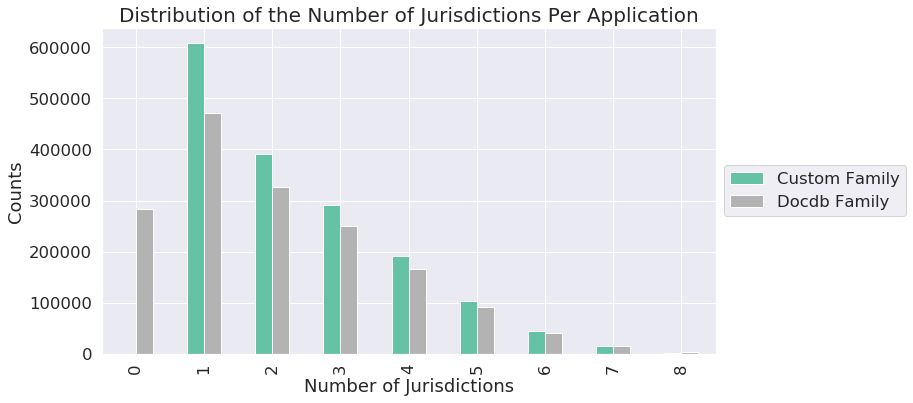

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(11,6))
df_plot.plot(ax=ax, kind='bar', colormap='Set2')
ax.bar
ax.set_xlabel('Number of Jurisdictions', fontsize=18)
ax.set_ylabel('Counts', fontsize=18)
ax.set_title('Distribution of the Number of Jurisdictions Per Application', fontsize=20)
ax.legend(['Custom Family', 'Docdb Family'], # you can send a list to change the legends
          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
#ax.set_yscale('log')
#ax.set_xticks(ax.get_xticks()) # list of xticks positions
#ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':16}, rotation=45, ha='right') #or rotation='horizontal'

plt.show()

## Adding country of origin

**Data Scources:**  
1. List of Muslim countries were taken from [this Wikipedia page](https://en.wikipedia.org/wiki/Islam_by_country)
    - We only chosed Muslim countries with more than 70% of Muslim population and ranked them based on their number of Muslim population
2. List of English-speaking counries were taken from the following sources:
    - Native English Speaking: [UK Government](https://www.gov.uk/english-language/exemptions) for considering countries were their natice language is English
    - English is the Official and Educational (and/or "lingua franca") language: [Wikipedia page](https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language)
3. List of countries with Anlgo-saxon model: [Wikipedia page](https://en.wikipedia.org/wiki/Anglo-Saxon_model)

In [ ]:
#df_musilm = pd.read_clipboard(sep='\t').iloc[:,:4]
#df_muslim.to_csv('./data/my_results/muslim_countries.csv', encoding='utf-8', index=False)
df_muslim.head()

In [4]:
df_muslim = pd.read_csv('./data/my_results/muslim_country_code.csv', low_memory=False)
df_muslim.head(2)

,Country/Region,country_code,Total Population,Muslim Population,Muslim percentage (%) of total population
0,Mauritania,MR,3840429,3840429,100.0
1,Somalia,SO,11000000,10978000,99.8


In [5]:
muslim_countries = df_muslim.sort_values(by=['Muslim Population'], ascending=False).reset_index(drop=True).iloc[:41,1].tolist()
english_speaking_countries = ['AG', 'AU', 'BS', 'BB', 'BZ', 'CA', 'DM', 'GD', 'GY', 'IE', 'JM', 'NZ', 'KN', 'LC', 'VC', 'TT', 'UK', 'GB', 'US', #From gov.uk
                              'KE', 'MT', 'NA', 'SG', 'GH', #from Wikipedia
                              'IN', 'NG', 'PK', 'RW', 'ZA', 'UG', 'ZW'] #  from Wikipedia

In [19]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

query_params = [
    bigquery.ArrayQueryParameter('muslim_countries', 'STRING', muslim_countries),
    bigquery.ArrayQueryParameter('english_speaking_countries', 'STRING', english_speaking_countries)
]

job_config.query_parameters = query_params

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '7_appln_exInvt_origin'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

## Note: Here I used MAX() for getting the numbers, since for any CASE where the first two conditions are not met, 
##...then we will get -1 (if that auth exists in docdb_family).
query= """
WITH appln_t AS(
    SELECT appln_id_1 AS appln_id, ARRAY_AGG(appln_id_2) AS twins_array
    FROM `usptobias.usptobias_dataset.4_exact_twins`
    GROUP BY appln_id
), invt_t AS(
    SELECT 
        appln_id, 
        ARRAY_AGG(invt_country_origin) AS invt_country_array, 
        ARRAY_AGG(invt_sub_reg_origin) AS invt_region_array,
        (CASE WHEN AVG(CASE WHEN invt_country_code IN('UK', 'GB',  'US', 'CA', 'NZ', 'AU', 'IE') THEN 1 ELSE 0 END)>0.5 THEN 1 
         ELSE 0 END) AS invt_angSax,
        (CASE WHEN AVG(CASE WHEN invt_country_code IN UNNEST(@english_speaking_countries) THEN 1 ELSE 0 END)>0.5 THEN 1
         ELSE 0 END) AS invt_eng,
        (CASE WHEN AVG(CASE WHEN invt_country_code IN('US') THEN 0 ELSE 1 END)>0 THEN 1
         ELSE 0 END) AS invt_foreign,
        MAX(CASE WHEN invt_country_code IN('US') THEN 0 ELSE 1 END) AS invt_foreign_exist,
        (CASE WHEN AVG(CASE WHEN invt_gender='male' THEN 0 WHEN invt_gender='female' THEN 1 END)>0.5 THEN 1
         ELSE 0 END) AS invt_female,
        (CASE WHEN AVG(CASE WHEN invt_ethnicity='Muslim' THEN 1 ELSE 0 END)>0.5 THEN 1
         ELSE 0 END) AS invt_muslim,
        #MAX(CASE WHEN invt_ethnicity='Muslim' THEN 1 ELSE 0 END) AS invt_muslim,
        (CASE WHEN AVG(CASE WHEN invt_country_origin IN('CN')  THEN 1 ELSE 0 END)>0.5 THEN 1
         ELSE 0 END) AS invt_chinese,
         #MAX(CASE WHEN invt_country_origin='CN' THEN 1 ELSE 0 END) AS invt_chinese,
        (CASE WHEN AVG(CASE WHEN invt_country_origin IN('JP')  THEN 1 ELSE 0 END)>0.5 THEN 1
         ELSE 0 END) AS invt_japanese,
        MAX(invt_gdppc) AS invt_gdppc,
        (CASE WHEN AVG(CASE WHEN invt_ethnicity='EastAsian' THEN 1 ELSE 0 END)>0.5 THEN 1
         ELSE 0 END) AS invt_eastasian,
        (CASE WHEN AVG(CASE WHEN invt_country_code IN('CN')  THEN 1 ELSE 0 END)>0.5 THEN 1
         ELSE 0 END) AS invt_res_china
    FROM `usptobias.usptobias_dataset.2_inventors_uspto_update`
    GROUP BY appln_id
), t1 AS(
    SELECT 
        examiner_id, examiner_country_origin, examiner_sub_reg_origin, examiner_ethnicity, 
        (CASE WHEN examiner_gender='male' THEN 0 WHEN examiner_gender='female' THEN 1 END) AS examiner_female
    FROM `usptobias.usptobias_dataset.3_examiners_uid_update`
), exam_t AS(
    SELECT 
        appln_id, examiner_id, examiner_country_origin, examiner_sub_reg_origin, examiner_female,
        (CASE WHEN examiner_ethnicity='Muslim' THEN 1 ELSE 0 END) AS examiner_muslim,
        #(CASE WHEN examiner_country_origin IN UNNEST(@muslim_countries) THEN 1 ELSE 0 END) AS examiner_muslim,
        (CASE WHEN examiner_country_origin IN('CN')  THEN 1 ELSE 0 END) AS examiner_chinese,
        (CASE WHEN examiner_country_origin IN('JP')  THEN 1 ELSE 0 END) AS examiner_japanese,
        (CASE WHEN examiner_country_origin IN('US')  THEN 1 ELSE 0 END) AS examiner_US
    FROM(
        SELECT appln_id, examiner_id
        FROM `usptobias.usptobias_dataset.3_uspto_data`
    ) AS a
    LEFT JOIN t1 USING(examiner_id)
), assignee_t AS(
    SELECT 
        appln_id, 
        (CASE WHEN AVG(CASE WHEN assignee_country_code IN('CN') THEN 1 ELSE 0 END)>0.5 THEN 1
         ELSE 0 END) AS assignee_china
    FROM `usptobias.usptobias_dataset.2_assignee_appln`
    GROUP BY appln_id
)

SELECT 
    appln_id,
    (CASE 
        WHEN ARRAY_LENGTH(invt_country_array)=0 THEN NULL
        WHEN examiner_country_origin IN((SELECT invt_country FROM UNNEST(invt_country_array) AS invt_country)) THEN 1 
     ELSE 0 END) AS same_country_origin,
    (CASE 
        WHEN ARRAY_LENGTH(invt_region_array)=0 THEN NULL
        WHEN examiner_sub_reg_origin IN((SELECT invt_region FROM UNNEST(invt_region_array) AS invt_region)) THEN 1 
     ELSE 0 END) AS same_reg_origin,
    examiner_muslim,
    examiner_chinese,
    examiner_japanese,
    examiner_female,
    examiner_US,
    examiner_country_origin,
    invt_angSax,
    invt_eng,
    invt_foreign,
    invt_foreign_exist,
    invt_muslim,
    invt_chinese,
    invt_japanese,
    invt_female,
    invt_gdppc,
    invt_eastasian,
    invt_res_china,
    assignee_china
FROM appln_t
LEFT JOIN invt_t USING(appln_id)
LEFT JOIN exam_t USING(appln_id)
LEFT JOIN assignee_t USING(appln_id)
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

### Creating portfolio size feature

In [4]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '7_patent_portfolio'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref
query="""
WITH t1 AS(
    SELECT appln_id, assignee_id, appln_filing_date AS filing_date
    FROM `usptobias.usptobias_dataset.2_pure_assignee_appln`
    LEFT JOIN (
        SELECT appln_id, appln_filing_date
        FROM  `usptobias.patstat.tls201`
    ) USING(appln_id)
), t2 AS(
    SELECT assignee_id, ARRAY_AGG(STRUCT(appln_id, filing_date)) AS filing_arr
    FROM t1
    GROUP BY assignee_id
), t3 AS(
    SELECT
        t1.appln_id,
        t2.assignee_id,
        t1.filing_date AS filing_date_curr,
        t2.filing_arr
    FROM t1
    INNER JOIN t2 ON t1.assignee_id=t2.assignee_id
)

SELECT 
    t3.appln_id, 
    COUNT(CASE WHEN (filing_date_curr>f_list.filing_date) AND 
                    (DATE_SUB(filing_date_curr, INTERVAL 5 YEAR)<f_list.filing_date) 
               THEN 1 END) AS portfolio_size
FROM t3, UNNEST(t3.filing_arr) AS f_list
GROUP BY t3.appln_id

"""

# Running the query
query_job = client.query(query, location='US', job_config=job_config)
query_job.result()

In [9]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

query_params = [
    bigquery.ArrayQueryParameter('muslim_countries', 'STRING', muslim_countries),
    bigquery.ArrayQueryParameter('english_speaking_countries', 'STRING', english_speaking_countries)
]

job_config.query_parameters = query_params

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '7_appln_exInvt_origin_patstat'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

## Note: Here I used MAX() for getting the numbers, since for any CASE where the first two conditions are not met, 
##...then we will get -1 (if that auth exists in docdb_family).
query= """
WITH appln_t AS(
    SELECT appln_id_1 AS appln_id, ARRAY_AGG(appln_id_2) AS twins_array
    FROM `usptobias.usptobias_dataset.4_exact_twins`
    GROUP BY appln_id
), invt_t AS(
    SELECT 
        appln_id, 
        COUNT(CASE WHEN invt_seq_nr>0 THEN invt_seq_nr END) AS nb_invt, 
        MAX(is_US_resident) AS invt_is_US_resident,
        MAX(CASE WHEN invt_country_code IN('UK', 'GB',  'US', 'CA', 'NZ', 'AU', 'IE') THEN 1 ELSE 0 END) AS invt_is_angSax,
        MAX(CASE WHEN invt_country_code IN UNNEST(@english_speaking_countries) THEN 1 ELSE 0 END) AS invt_is_eng,
    FROM `usptobias.usptobias_dataset.2_inventors_patstat`
    GROUP BY appln_id
), t1 AS(
    SELECT examiner_id, examiner_country_origin, examiner_sub_reg_origin
    FROM `usptobias.usptobias_dataset.3_examiners_uid_update`
), exam_t AS(
    SELECT 
        appln_id, examiner_id, examiner_country_origin, examiner_sub_reg_origin,
        (CASE WHEN examiner_country_origin IN UNNEST(@muslim_countries) THEN 1 ELSE 0 END) AS examiner_is_muslim,
        (CASE WHEN examiner_country_origin IN('CN', 'HK')  THEN 1 ELSE 0 END) AS examiner_is_chinese
    FROM(
        SELECT appln_id, examiner_id
        FROM `usptobias.usptobias_dataset.3_uspto_data`
    ) AS a
    LEFT JOIN t1 USING(examiner_id)
)

SELECT 
    appln_id,
    nb_invt,
    invt_is_US_resident,
    examiner_is_muslim,
    examiner_is_chinese,
    invt_is_angSax,
    invt_is_eng
FROM appln_t
LEFT JOIN invt_t USING(appln_id)
LEFT JOIN exam_t USING(appln_id)
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

### 6.1.2. Another method for checking the validity of custom family ID

Looking at the families which are not whithin `DOCDB_family_id` but exists in our `cutoms_family_id` will give us a proxy to check whether those families that we have found are valid of not!

**For example:**

In [ ]:
%%bigquery df_

SELECT *
FROM `usptobias.usptobias_dataset.6_processed_exact_twins_initial`
WHERE (twin_EP<>-1 AND twin_EP_min<>-1) AND (twin_JP<>-1 AND twin_JP_min<>-1)
LIMIT 1000

In [17]:
df_.head()

,appln_id_US,family_id,appln_filing_year_US,granted_US,twin_EP,twin_EP_min,twin_JP,twin_JP_min,twin_CN,twin_CN_min,twin_KR,twin_KR_min,twin_DE,twin_DE_min,twin_CA,twin_CA_min,twin_AU,twin_AU_min,twin_TW,twin_TW_min
0,496036617,443527980,2018,False,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1,53165448,53165448,1976,True,1,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,NaN,NaN,None,None
2,52923857,52923857,1976,True,1,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,None,None
3,906037838,906037838,1977,False,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
4,906069805,906069805,1977,False,1,1,0,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,None,None


In [18]:
%%bigquery
WITH t1 AS(
    SELECT *
    FROM `usptobias.usptobias_dataset.4_family_custom_PCT` 
    WHERE family_id=443527980
), t2 AS(
SELECT *
FROM `usptobias.usptobias_dataset.5_match_applnNrOrig_applnId`
), t3 AS(
    SELECT 
        application_number AS appln_nr_orig,
        publication_number AS publn_nr
    FROM `patents-public-data.patents.publications`
)

SELECT *
FROM t1
LEFT JOIN t2 USING(appln_id)
LEFT JOIN t3 USING(appln_nr_orig)

,appln_nr_orig,appln_id,appln_auth,family_id,publn_nr
0,US-2016028052-W,471239631,WO,443527980,WO-2016178813-A1
1,US-201514702961-A,443527980,US,443527980,US-2015230887-A1
2,KR-20177031720-A,488700067,KR,443527980,KR-20170141702-A
3,JP-2017555622-A,495780478,JP,443527980,JP-2018514285-A
4,EP-16789743-A,471258600,EP,443527980,EP-3291764-A4
5,EP-16789743-A,471258600,EP,443527980,EP-3291764-A1
6,US-201815895190-A,496036617,US,443527980,US-2018168777-A1
7,CN-201680026956-A,488120573,CN,443527980,CN-107530152-A


## 6.2. Building the Final Dataset

In [20]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '8_final_dataset'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

## Note: Here I used MAX() for getting the numbers, since for any CASE where the first two conditions are not met, 
##...then we will get -1 (if that auth exists in docdb_family).
query= """
WITH t1 AS(
    SELECT appln_id, attorney_id
    FROM `usptobias.usptobias_dataset.1_applnId_attorney`
), t2 AS(
    SELECT *
    FROM `usptobias.usptobias_dataset.2_applnId_invt_claims`
), t3 AS(
    SELECT *
    FROM `usptobias.usptobias_dataset.3_uspto_data`
), t4 AS(
    SELECT *
    FROM `usptobias.usptobias_dataset.7_processed_exact_twins`
), t5 AS(
    SELECT *
    FROM `usptobias.usptobias_dataset.7_appln_exInvt_origin`
    WHERE examiner_muslim IS NOT NULL AND invt_eng IS NOT NULL
), t6 AS(
    SELECT appln_id, assignee_id
    FROM `usptobias.usptobias_dataset.2_pure_assignee_appln`
), t7 AS(
    SELECT assignee_id, attorney_id, grant_rate AS attorney_FE
    FROM `usptobias.usptobias_dataset.2_attorney_FE_on_assignee`
), t8 AS(
    SELECT assignee_id, examiner_id, grant_rate AS examiner_FE
    FROM `usptobias.usptobias_dataset.3_examiner_FE_on_assignee`
), t9 AS(
    SELECT assignee_id, examiner_art_unit, grant_rate AS artunit_FE
    FROM `usptobias.usptobias_dataset.3_artunit_FE_on_assignee`
), t10 AS(
    SELECT appln_id, portfolio_size
    FROM `usptobias.usptobias_dataset.7_patent_portfolio`
)

SELECT 
    t4.*,
    t1.attorney_id AS attorney_id_US,
    t2.publn_claims_earliest AS publn_claims_earliest_US, t2.publn_claims_grant AS publn_claims_grant, 
    t2.publn_date_earliest AS publn_date_earliest_US, t2.publn_date_grant AS publn_date_grant_US, 
    t2.nb_applt AS nb_applt_US, t2.nb_invt AS nb_invt_US,
    t3.* EXCEPT(appln_id),
    t5.* EXCEPT(appln_id),
    t6.assignee_id,
    t7.attorney_FE,
    t8.examiner_FE,
    t9.artunit_FE,
    t10.portfolio_size
FROM t4
LEFT JOIN t1 ON t4.appln_id_US=t1.appln_id
LEFT JOIN t2 ON t4.appln_id_US=t2.appln_id
LEFT JOIN t3 ON t4.appln_id_US=t3.appln_id
LEFT JOIN t5 ON t4.appln_id_US=t5.appln_id
LEFT JOIN t6 ON t4.appln_id_US=t6.appln_id
LEFT JOIN t10 ON t4.appln_id_US=t10.appln_id
LEFT JOIN t7 ON t6.assignee_id=t7.assignee_id AND t1.attorney_id=t7.attorney_id
LEFT JOIN t8 ON t6.assignee_id=t8.assignee_id AND t3.examiner_id=t8.examiner_id
LEFT JOIN t9 ON t6.assignee_id=t9.assignee_id AND t3.examiner_art_unit=t9.examiner_art_unit
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

Checking number of Nulls in the final table

In [21]:
%%bigquery

SELECT 
    COUNT(DISTINCT CASE WHEN filing_date IS NULL THEN appln_id_US END) AS nb_pair_null,
    COUNT(DISTINCT CASE WHEN nb_applt IS NULL THEN appln_id_US END) AS nb_null,
    COUNT(DISTINCT CASE WHEN (nb_applt IS NULL) AND (filing_date IS NULL) THEN appln_id_US END) AS nb_null_both,
    COUNT(*) AS nb_total
FROM `usptobias.usptobias_dataset.6_final_dataset` LIMIT 1000

,nb_pair_null,nb_null,nb_null_both,nb_total
0,1270041,613236,612992,4147284


In [90]:
%%bigquery

SELECT 
    'Final Dataset' AS name,
    COUNT(DISTINCT CASE WHEN nb_office_actions IS NULL THEN appln_id_US END) AS nb_null_office_actions, 
    COUNT(DISTINCT CASE WHEN status_code IS NULL THEN appln_id_US END) AS nb_null_status,
    COUNT(DISTINCT CASE WHEN filing_date IS NULL THEN appln_id_US END) AS nb_null_filing, 
    COUNT(DISTINCT appln_id_US) AS nb_total
FROM `usptobias.usptobias_dataset.6_final_dataset`
WHERE appln_filing_year_US between 2001 AND 2012
UNION ALL
SELECT 
    '3_USPTO_Data' AS name,
    COUNT(DISTINCT CASE WHEN nb_office_actions IS NULL THEN appln_id END) AS nb_null_office_actions, 
    COUNT(DISTINCT CASE WHEN status_code IS NULL THEN appln_id END) AS nb_null_status,
    COUNT(DISTINCT CASE WHEN filing_date IS NULL THEN appln_id END) AS nb_null_filing, 
    COUNT(DISTINCT appln_id) AS nb_total
FROM `usptobias.usptobias_dataset.3_uspto_data`
WHERE EXTRACT(year FROM filing_date) BETWEEN 2001 AND 2012

,name,nb_null_office_actions,nb_null_status,nb_null_filing,nb_total
0,Final Dataset,244738,244852,245022,1759212
1,3_USPTO_Data,0,1,0,4543148


In [21]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'usptobias_dataset'
table_id = '8_final_dataset_2002_2012'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

## Note: Here I used MAX() for getting the numbers, since for any CASE where the first two conditions are not met, 
##...then we will get -1 (if that auth exists in docdb_family).
query= """
SELECT *
FROM `usptobias.usptobias_dataset.8_final_dataset`
WHERE appln_filing_year_US BETWEEN 2002 AND 2012
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [11]:
# Exctracting table
client = bigquery.Client()

# Set Source table
project_id = 'usptobias'
dataset_id = 'usptobias_dataset'
table_id = '8_final_dataset_2002_2012'
table_ref = client.dataset(dataset_id, project=project_id).table(table_id)

# Set Destination
dest_bucket = 'uspto-data'
dest_file_name = 'final_dataset_11.csv'
dest_uri = "gs://{}/{}".format(dest_bucket, dest_file_name)

extract_job = client.extract_table(table_ref, dest_uri, location='US')
print('Extract job has {} started!'.format(extract_job.job_id))
extract_job.result()
print('Job has finished and table {} has been exported to {} bucket!'.format(dest_file_name, dest_bucket))

Extract job has e2ee2658-7889-4ac2-a655-624b95c10a20 started!
Job has finished and table final_dataset_11.csv has been exported to uspto-data bucket!


In [14]:
# Exctracting table
client = bigquery.Client()

# Set Source table
project_id = 'usptobias'
dataset_id = 'usptobias_dataset'
table_id = '4_family_custom_PCT'
table_ref = client.dataset(dataset_id, project=project_id).table(table_id)

# Set Destination
dest_bucket = 'uspto-data'
dest_file_name = 'Family_customDef_*.csv'
dest_uri = "gs://{}/{}".format(dest_bucket, dest_file_name)

extract_job = client.extract_table(table_ref, dest_uri, location='US')
print('Extract job has {} started!'.format(extract_job.job_id))
extract_job.result()
print('Job has finished and table {} has been exported to {} bucket!'.format(dest_file_name, dest_bucket))

Extract job has c74e6ef2-2980-446c-ba8b-ed6818162614 started!
Job has finished and table Family_customDef_*.csv has been exported to uspto-data bucket!


In [47]:
import requests
import json

In [ ]:
curl --data text="Dylan was born in Duluth." 

In [73]:
url = 'https://gate.d5.mpi-inf.mpg.de/aida/service/disambiguate'
#payload = open("request.json")
text = 'Zenith Radio Corp is founded in 1999!'
data= dict(text=text)
r = requests.post(url, data=data)
content_l = json.loads(r.content)
print(json.dumps(list(content_l['entityMetadata'].values())[0]['entityId'], indent=4))

KeyError: 'entityId'

In [64]:
content_l['mentions'][0]['name']

'ZENITH RADIO CORP'

In [52]:
print(json.dumps(content_l, indent=4, sort_keys=False))

{
    "originalFileName": null,
    "originalText": "ZENECA INC PATENT AND TRADEMARK ADMIN is founded in 1999!",
    "overallTime": "162",
    "allEntities": [],
    "entityMetadata": {
        "AIDA:--OOKBE--": {}
    },
    "annotatedText": "[[AIDA:--OOKBE--|ZENECA INC]] PATENT AND TRADEMARK ADMIN is founded in 1999!",
    "docID": "-168232108_1560015606172",
    "mentions": [
        {
            "allEntities": [],
            "offset": 0,
            "name": "ZENECA INC",
            "length": 10
        }
    ],
    "formatVersion": "2.3",
    "allTypes": []
}


In [3]:
df_ = pd.read_csv('./data/USPTO/lawyer/lawyer.csv', low_memory=False)
print(df_.shape)
df_.head()

(2718997, 6)


,Patent,Firstname,Lastname,LawCountry,OrgName,LawSeq
0,05705896,NaN,NaN,unknown,CUSHMAN DARBY & CUSHMAN IP GROUP OF PILLSBURY ...,0
1,05705444,ALLEN;,D.,unknown,NaN,2
2,05705461,AYLOR;,B.,unknown,NaN,0
3,05705427,JORGENSON;,K.,unknown,NaN,1
4,05705970,NaN,NaN,unknown,"SUGHRUE, MION, ZINN, MACPEAK, AND SEAS",0


In [7]:
print('{:,}'.format(df_.drop_duplicates(subset=['Firstname', 'Lastname', 'OrgName']).shape[0]))

106,460


In [8]:
import re

In [42]:
txt = ' This,!$#%^)!(@_) IBM    INC. 9 '

In [45]:
text_rep = re.sub(r'[^a-zA-Z0-9\s]+', '', txt)
text_rep = re.sub(r'[\s]+', ' ', text_rep)
re.sub(r'(^\s+)|(\s+$)', '', text_rep)

'This IBM INC 9'

In [75]:
txt = '   '
txt.strip()

''

## Getting Variable Names

In [22]:
%%bigquery df_

SELECT
 * EXCEPT(is_generated, generation_expression, is_stored, is_updatable)
FROM
 `usptobias`.usptobias_dataset.INFORMATION_SCHEMA.COLUMNS
ORDER BY column_name

In [32]:
df_[['column_name', 'data_type', 'table_name']].groupby(['column_name', 'data_type'])['table_name'].apply(list) \
    .to_csv('./data/final_results/var_list.csv', encoding='utf-8', index=True)

## Investigating Examiners that are discriminating a lot for Chinese Applicants

In [33]:
%%bigquery df_

SELECT *
FROM `usptobias.usptobias_dataset.3_examiners_uid_update`
WHERE examiner_id IN('90034', '92979', '96308', '67112', '65680', '77878', '62250', '67437', '66946', '71909', '72307',
                     '59174', '91324', '91470', '60911', '97926', '60574', '94182', '60407', '61865', '99918', '94670',
                     '68598', '59559', '64013', '72513', '60209', '65568')

In [37]:
df_.drop_duplicates().sort_values(by=['examiner_art_unit'])

,examiner_id,examiner_name_first,examiner_name_middle,examiner_name_last,examiner_art_unit,examiner_gender,examiner_country_origin,examiner_sub_reg_origin,examiner_ethnicity
46,71909,JOHN,MATTHEW,MAURO,1622,male,IT,Southern Europe,Hispanic
44,72307,SABIHA,NAIM,QAZI,1629,female,PK,Southern Asia,SouthAsian
19,67112,MICHAEL,C,WILSON,1633,male,GB,Northern Europe,English
11,67437,ANGELO,None,TRIVISONNO,1755,male,IT,Southern Europe,European
14,64013,ELIZABETH,A,ROBINSON,1794,female,GB,Northern Europe,English
39,66946,WILLIAM,W,MOORE,1814,male,GB,Northern Europe,English
23,62250,NICHOLAS,E,ALLEN,2167,male,GB,Northern Europe,English
32,77878,CHAU,T,NGUYEN,2177,male,VN,South-Eastern Asia,EastAsian
25,65680,MOHAMMAD,H,KABIR,2198,male,BD,Southern Asia,Muslim
45,60574,ESTHER,BENOIT,HENDERSON,2458,female,GB,Northern Europe,English
